 # Extracting Temperature and Salinity Data
 ## GIOPS and RIOPS

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe

The request is to extract the following data:

    I need daily RIOPS and GIOPS Temp, Salinity (O2 if available) 
    data along a straight line connecting: 

    longitude -53.0 to -51.8 E
    latitude 56.4 to 57 N

    Time window: Oct 03 to November 22, 2016

Declare the time range and bounding box of interest.

In [2]:
time = slice('2016-10-03', '2016-11-22')
lat0, lat1 = 56.4, 57.0
lon0, lon1 = -53.0, -51.8

We can extract GIOPS and RIOPS daily data by connecting to a THREDDS server.

In [3]:
giops_url = "http://navigator.oceansdata.ca/thredds/dodsC/giops/daily/aggregated.ncml"
riops_url = "http://navigator.oceansdata.ca/thredds/dodsC/riops/daily/aggregated.ncml"

(these next commands can take a couple of minutes, *patience*)

In [4]:
giops_all = xr.open_dataset(giops_url)

In [5]:
riops_all = xr.open_dataset(riops_url)

Here is what is available for GIOPS,

In [6]:
giops_all

<xarray.Dataset>
Dimensions:       (depth: 50, time_counter: 1115, x: 1442, y: 1021)
Coordinates:
    nav_lat       (y, x) float32 ...
    nav_lon       (y, x) float32 ...
  * depth         (depth) float32 0.494025 1.54138 2.64567 ... 5274.78 5727.92
  * time_counter  (time_counter) datetime64[ns] 2016-03-08 ... 2019-03-28
Dimensions without coordinates: x, y
Data variables:
    vozocrtx      (time_counter, depth, y, x) float32 ...
    vomecrty      (time_counter, depth, y, x) float32 ...
    votemper      (time_counter, depth, y, x) float32 ...
    vosaline      (time_counter, depth, y, x) float32 ...
    sossheig      (time_counter, y, x) float32 ...
    aice          (time_counter, y, x) float32 ...
    vice          (time_counter, y, x) float32 ...
Attributes:
    conventions:      CF-1.6
    title:            Time-averaged sea ice and ocean forecast fields
    institution:      Canadian Centre for Meteorological and Environmental Pr...
    source:           Global Ice Ocean Predic

and for RIOPS

In [7]:
riops_all

<xarray.Dataset>
Dimensions:              (depth: 50, time: 972, xc: 1770, yc: 1610)
Coordinates:
  * depth                (depth) float32 0.494025 1.54138 ... 5274.78 5727.92
  * xc                   (xc) float32 0.0 5000.0 10000.0 ... 8840000.0 8845000.0
  * yc                   (yc) float32 0.0 5000.0 10000.0 ... 8040000.0 8045000.0
  * time                 (time) datetime64[ns] 2016-07-19T13:30:00 ... 2019-03-26T13:30:00
    latitude             (yc, xc) float32 ...
    longitude            (yc, xc) float32 ...
Data variables:
    polar_stereographic  |S64 ...
    vomecrty             (time, depth, yc, xc) float32 ...
    vosaline             (time, depth, yc, xc) float32 ...
    votemper             (time, depth, yc, xc) float32 ...
    vozocrtx             (time, depth, yc, xc) float32 ...
    iiceconc             (time, yc, xc) float32 ...
    iicepressure         (time, yc, xc) float32 ...
    iicestrength         (time, yc, xc) float32 ...
    iicesurftemp         (time, yc, x

These models do not model O2, but we can extract out temperature (`votemper`) and salinity (`vosaline`).

Let's create datasets that focus in on our variables of interest (T and S) for the time range specified. We also rename some of the variables to be the same between the two models.

In [8]:
giops = xr.Dataset( {'T':giops_all.votemper, 'S':giops_all.vosaline} )
giops = giops.rename({'nav_lat':'lat', 'nav_lon':'lon', 'time_counter': 'time'})
giops = giops.sel(time=time)
giops

<xarray.Dataset>
Dimensions:  (depth: 50, time: 51, x: 1442, y: 1021)
Coordinates:
    lat      (y, x) float32 -77.010475 -77.010475 ... 49.988163 49.98644
    lon      (y, x) float32 72.75 73.0 73.25 73.5 ... 73.019714 73.00464 73.0
  * depth    (depth) float32 0.494025 1.54138 2.64567 ... 5274.78 5727.92
  * time     (time) datetime64[ns] 2016-10-03 2016-10-04 ... 2016-11-22
Dimensions without coordinates: x, y
Data variables:
    T        (time, depth, y, x) float32 ...
    S        (time, depth, y, x) float32 ...

In [9]:
riops = xr.Dataset( {'T':riops_all.votemper, 'S':riops_all.vosaline} )
riops = riops.rename({'latitude':'lat', 'longitude':'lon'})
riops = riops.sel(time=time)
riops

<xarray.Dataset>
Dimensions:  (depth: 50, time: 51, xc: 1770, yc: 1610)
Coordinates:
  * depth    (depth) float32 0.494025 1.54138 2.64567 ... 5274.78 5727.92
  * xc       (xc) float32 0.0 5000.0 10000.0 ... 8835000.0 8840000.0 8845000.0
  * yc       (yc) float32 0.0 5000.0 10000.0 ... 8035000.0 8040000.0 8045000.0
  * time     (time) datetime64[ns] 2016-10-03T13:30:00 ... 2016-11-22T13:30:00
    lat      (yc, xc) float32 30.56034 30.58307 30.60579 ... 41.50174 41.46735
    lon      (yc, xc) float32 221.2824 221.31534 221.34833 ... 20.89783 20.87038
Data variables:
    T        (time, depth, yc, xc) float32 ...
    S        (time, depth, yc, xc) float32 ...

We can plot these datasets with the correct geographical projection.

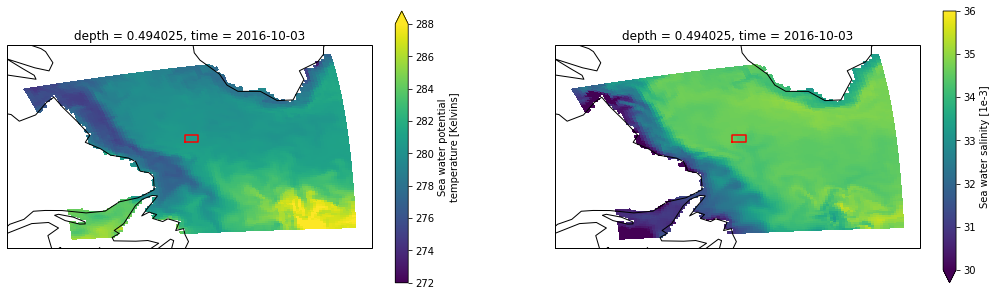

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,5), subplot_kw={'projection': ccrs.PlateCarree()})

giops.isel(x=slice(900,1000), y=slice(720,820)).isel(time=0, depth=0).T\
     .plot(ax=ax1, x='lon', y='lat', vmin=272, vmax=288)
ax1.plot([lon0, lon0, lon1, lon1, lon0], [lat0, lat1, lat1, lat0, lat0], 'r-')
ax1.coastlines()

giops.isel(x=slice(900,1000), y=slice(720,820)).isel(time=0, depth=0).S\
     .plot(ax=ax2, x='lon', y='lat', vmin=30, vmax=36)
ax2.plot([lon0, lon0, lon1, lon1, lon0], [lat0, lat1, lat1, lat0, lat0], 'r-')
ax2.coastlines()

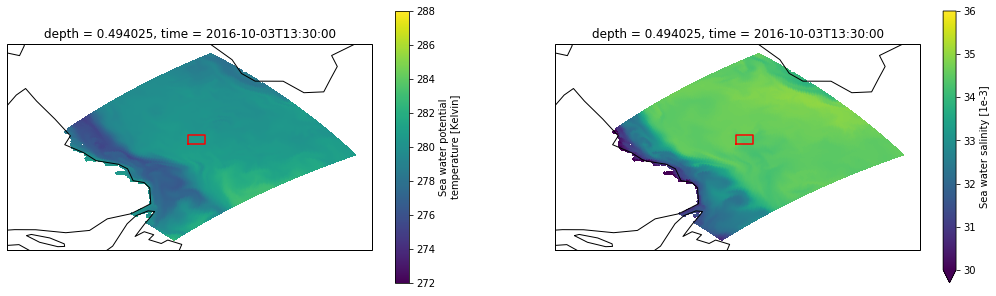

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,5), subplot_kw={'projection': ccrs.PlateCarree()})

riops.isel(xc=slice(1280, 1480), yc=slice(450, 680)).isel(time=0, depth=0).T\
     .plot(ax=ax1, x='lon', y='lat', vmin=272, vmax=288)
ax1.plot([lon0, lon0, lon1, lon1, lon0], [lat0, lat1, lat1, lat0, lat0], 'r-')

ax1.coastlines()
riops.isel(xc=slice(1280, 1480), yc=slice(450, 680)).isel(time=0, depth=0).S\
     .plot(ax=ax2, x='lon', y='lat', vmin=30, vmax=36)
ax2.plot([lon0, lon0, lon1, lon1, lon0], [lat0, lat1, lat1, lat0, lat0], 'r-')
ax2.coastlines()

We can adjust the domain so that we have coverage of our area of interest.

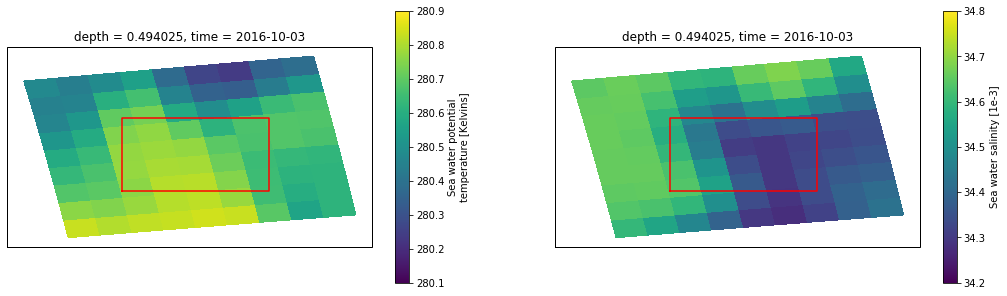

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,5), subplot_kw={'projection': ccrs.PlateCarree()})
giops_dr = giops.isel(x=slice(943,953), y=slice(770,780))
giops_dr.isel(time=0, depth=0).T\
    .plot(ax=ax1, x='lon', y='lat', vmin=280.1, vmax=280.9)
ax1.plot([lon0, lon0, lon1, lon1, lon0], [lat0, lat1, lat1, lat0, lat0], 'r-')
giops_dr.isel(time=0, depth=0).S\
    .plot(ax=ax2, x='lon', y='lat', vmin=34.2, vmax=34.8)
ax2.plot([lon0, lon0, lon1, lon1, lon0], [lat0, lat1, lat1, lat0, lat0], 'r-')

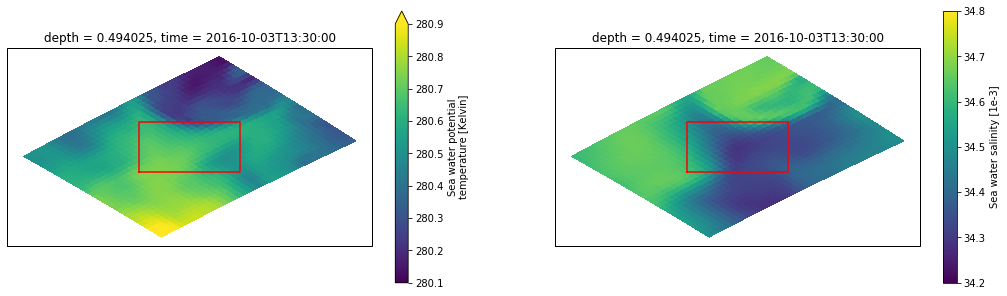

In [61]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,5), subplot_kw={'projection': ccrs.PlateCarree()})
riops_dr = riops.isel(xc=slice(1359, 1390), yc=slice(560, 600))
riops_dr.isel(time=0, depth=0).T\
    .plot(ax=ax1, x='lon', y='lat', vmin=280.1, vmax=280.9)
ax1.plot([lon0, lon0, lon1, lon1, lon0], [lat0, lat1, lat1, lat0, lat0], 'r-')
riops_dr.isel(time=0, depth=0).S\
    .plot(ax=ax2, x='lon', y='lat', vmin=34.2, vmax=34.8)
ax2.plot([lon0, lon0, lon1, lon1, lon0], [lat0, lat1, lat1, lat0, lat0], 'r-')


We now need to project this data on to a regular lat-lon grid. There is no point overinterpolating the data. Let's create grids which are close to the scale of the original datasets.

In [62]:
def estimate_delta(coords, dim):
    # given coordinates corrds, e.g. giops.lat
    # estimate the spacing along dimension dim, e.g. 'x'
    diff = coords.diff(dim)
    mean = diff.mean().values
    # round to four decimal points
    return np.round(mean, 4)

giops_dlon = estimate_delta(giops_dr.lon, 'x')
giops_dlat = estimate_delta(giops_dr.lat, 'y')
riops_dlon = estimate_delta(riops_dr.lon, 'xc')
riops_dlat = estimate_delta(riops_dr.lat, 'yc')

print('giops Δlat=', giops_dlat, 'Δlon=', giops_dlon)
print('riops Δlat=', riops_dlat, 'Δlon=', riops_dlon)


giops Δlat= 0.1433 Δlon= 0.2624
riops Δlat= 0.0298 Δlon= 0.0543


We could also override these choices if we wanted.  We are going to interpolate to a domain a fifth-degree larger than our target area.

(**This step takes time...**)

In [82]:
giops_out = xe.util.grid_2d(lon0-0.2, lon1+0.2, giops_dlon, lat0 - 0.2, lat1 + 0.2, giops_dlat)
regridder = xe.Regridder(giops_dr, giops_out, 'bilinear', reuse_weights=False)
T = regridder(giops_dr.T)
S = regridder(giops_dr.S)
giops_new = xr.Dataset({'T': T, 'S': S})

/Users/jmunroe/anaconda3/envs/ocean/lib/python3.7/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


Overwrite existing file: bilinear_10x10_7x7.nc 
 You can set reuse_weights=True to save computing time.


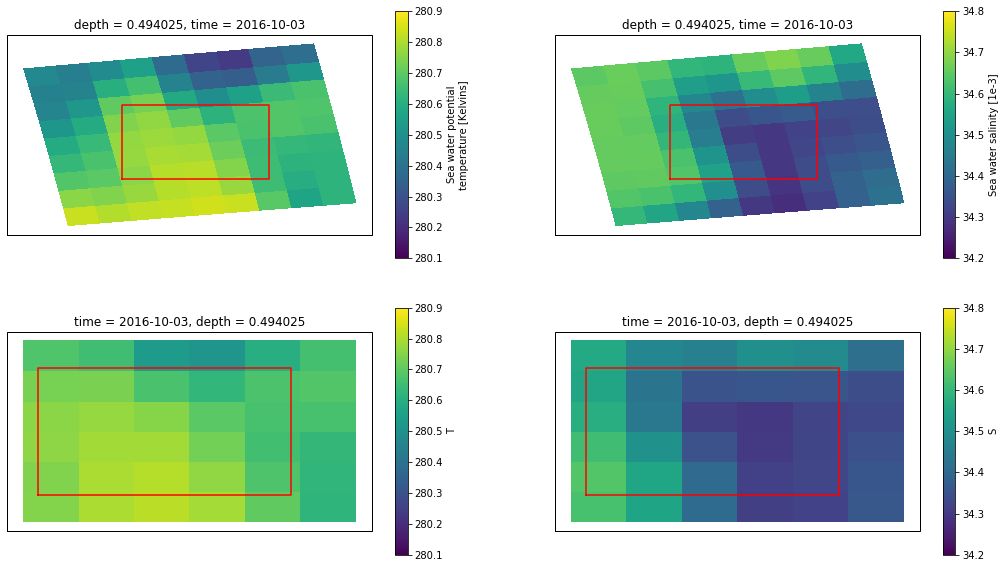

In [83]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18,10), subplot_kw={'projection': ccrs.PlateCarree()})

giops_dr.T.isel(time=0, depth=0)\
    .plot(ax=ax1, x='lon', y='lat', vmin=280.1, vmax=280.9)
ax1.plot([lon0, lon0, lon1, lon1, lon0], [lat0, lat1, lat1, lat0, lat0], 'r-')
giops_dr.S.isel(time=0, depth=0)\
    .plot(ax=ax2, x='lon', y='lat', vmin=34.2, vmax=34.8)
ax2.plot([lon0, lon0, lon1, lon1, lon0], [lat0, lat1, lat1, lat0, lat0], 'r-')

giops_new.T.isel(time=0, depth=0)\
    .plot(ax=ax3, x='lon', y='lat', vmin=280.1, vmax=280.9)
ax3.plot([lon0, lon0, lon1, lon1, lon0], [lat0, lat1, lat1, lat0, lat0], 'r-')
giops_new.S.isel(time=0, depth=0)\
    .plot(ax=ax4, x='lon', y='lat', vmin=34.2, vmax=34.8)
ax4.plot([lon0, lon0, lon1, lon1, lon0], [lat0, lat1, lat1, lat0, lat0], 'r-')

The above plot shows the original data `giops_dr` (top-row) and the interpolated/rotated data (bottom-row).

In [84]:
giops_new

<xarray.Dataset>
Dimensions:  (depth: 50, time: 51, x: 7, y: 7)
Coordinates:
    lon      (y, x) float64 -53.07 -52.81 -52.54 -52.28 ... -52.02 -51.76 -51.49
    lat      (y, x) float64 56.27 56.27 56.27 56.27 ... 57.13 57.13 57.13 57.13
  * time     (time) datetime64[ns] 2016-10-03 2016-10-04 ... 2016-11-22
  * depth    (depth) float32 0.494025 1.54138 2.64567 ... 5274.78 5727.92
Dimensions without coordinates: x, y
Data variables:
    T        (time, depth, y, x) float64 280.8 280.8 280.8 280.8 ... nan nan nan
    S        (time, depth, y, x) float64 34.62 34.55 34.41 34.31 ... nan nan nan

Save the data.

In [88]:
giops_new.to_netcdf('giops_subset.nc')

We can now do the same process with the RIOPS data.

(**This step takes time...**)

In [89]:
riops_out = xe.util.grid_2d(lon0-0.2, lon1+0.2, riops_dlon, lat0 - 0.2, lat1 + 0.2, riops_dlat)
regridder = xe.Regridder(riops_dr, riops_out, 'bilinear', reuse_weights=False)
T = regridder(riops_dr.T)
S = regridder(riops_dr.S)
riops_new = xr.Dataset({'T': T, 'S': S})

/Users/jmunroe/anaconda3/envs/ocean/lib/python3.7/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


Overwrite existing file: bilinear_40x31_34x30.nc 
 You can set reuse_weights=True to save computing time.


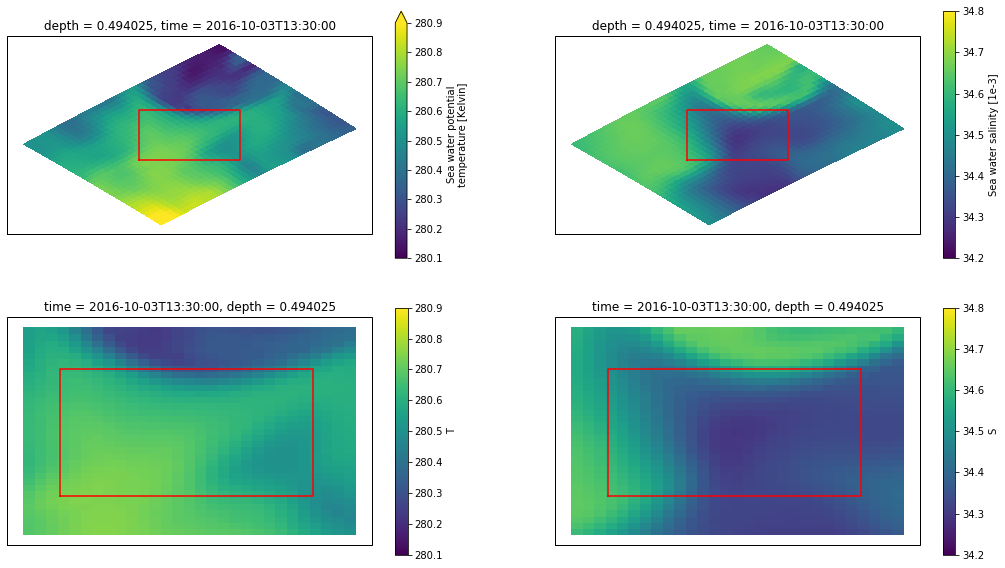

In [90]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18,10), subplot_kw={'projection': ccrs.PlateCarree()})

riops_dr.T.isel(time=0, depth=0)\
    .plot(ax=ax1, x='lon', y='lat', vmin=280.1, vmax=280.9)
ax1.plot([lon0, lon0, lon1, lon1, lon0], [lat0, lat1, lat1, lat0, lat0], 'r-')
riops_dr.S.isel(time=0, depth=0)\
    .plot(ax=ax2, x='lon', y='lat', vmin=34.2, vmax=34.8)
ax2.plot([lon0, lon0, lon1, lon1, lon0], [lat0, lat1, lat1, lat0, lat0], 'r-')

riops_new.T.isel(time=0, depth=0)\
    .plot(ax=ax3, x='lon', y='lat', vmin=280.1, vmax=280.9)
ax3.plot([lon0, lon0, lon1, lon1, lon0], [lat0, lat1, lat1, lat0, lat0], 'r-')
riops_new.S.isel(time=0, depth=0)\
    .plot(ax=ax4, x='lon', y='lat', vmin=34.2, vmax=34.8)
ax4.plot([lon0, lon0, lon1, lon1, lon0], [lat0, lat1, lat1, lat0, lat0], 'r-')

It appears that we have correctly interpolated the data on to a rectangular grid.

In [91]:
riops_new

<xarray.Dataset>
Dimensions:  (depth: 50, time: 51, x: 30, y: 34)
Coordinates:
    lon      (y, x) float64 -53.17 -53.12 -53.06 -53.01 ... -51.71 -51.65 -51.6
    lat      (y, x) float64 56.21 56.21 56.21 56.21 ... 57.2 57.2 57.2 57.2
  * time     (time) datetime64[ns] 2016-10-03T13:30:00 ... 2016-11-22T13:30:00
  * depth    (depth) float32 0.494025 1.54138 2.64567 ... 5274.78 5727.92
Dimensions without coordinates: x, y
Data variables:
    T        (time, depth, y, x) float64 280.7 280.7 280.7 280.7 ... nan nan nan
    S        (time, depth, y, x) float64 34.61 34.59 34.57 34.55 ... nan nan nan

Save the RIOPS subset.

In [92]:
riops_new.to_netcdf('riops_subset.nc')

Finally, let's make sure we can load these files

In [93]:
giops_loaded = xr.open_dataset('giops_subset.nc')
giops_loaded

<xarray.Dataset>
Dimensions:  (depth: 50, time: 51, x: 7, y: 7)
Coordinates:
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
  * time     (time) datetime64[ns] 2016-10-03 2016-10-04 ... 2016-11-22
  * depth    (depth) float32 0.494025 1.54138 2.64567 ... 5274.78 5727.92
Dimensions without coordinates: x, y
Data variables:
    T        (time, depth, y, x) float64 ...
    S        (time, depth, y, x) float64 ...

In [94]:
riops_loaded = xr.open_dataset('riops_subset.nc')
riops_loaded

<xarray.Dataset>
Dimensions:  (depth: 50, time: 51, x: 30, y: 34)
Coordinates:
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
  * time     (time) datetime64[ns] 2016-10-03T13:30:00 ... 2016-11-22T13:30:00
  * depth    (depth) float32 0.494025 1.54138 2.64567 ... 5274.78 5727.92
Dimensions without coordinates: x, y
Data variables:
    T        (time, depth, y, x) float64 ...
    S        (time, depth, y, x) float64 ...

In [95]:
giops_loaded.close()

In [96]:
riops_loaded.close()